In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/DataScience

/content/drive/MyDrive/DataScience


In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
import os
import re
import json
import math
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [ ]:
# Site being scraped from
url = 'https://www.teamrankings.com/ncb/stats/'

In [ ]:
# Page with team statistics
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
data = soup.find('ul', attrs={'class': 'chooser-list'})

In [ ]:
# Function for getting data frame for teams in the power five conferences plus big east
def getPowerFive():
  valid = ['Big East', 'Big 12', 'Big Ten', 'ACC', 'SEC', 'Pac-12']
  powerFive = {'Team': []}
  url = 'https://www.teamrankings.com/ncaa-basketball/stat/percent-of-points-from-3-pointers'
  r = requests.get(url)
  soup = BeautifulSoup(r.content, 'html.parser')
  table = soup.find('tbody')
  links = table.find_all('a')
  # Clicking through teams, getting their conference name and checking if valid
  for i, link in enumerate(links):
    team = link.text
    stub = link.get('href')
    r = requests.get(stub)
    soup = BeautifulSoup(r.content, 'html.parser')
    description = soup.find('td', attrs={'class': 'top', 'colspan': '3'}).text
    conference = description.split(' ')[2]
    if conference == "Big":
      conference = conference + ' ' + description.split(' ')[3]
    if conference in valid:
      powerFive['Team'].append(team)
  df = pd.DataFrame(powerFive)
  df.to_csv('powerFive.csv')
  return df

In [ ]:
getPowerFive()

,Team
0,Villanova
1,Wash State
2,VA Tech
3,Notre Dame
4,Penn State
...,...
71,Virginia
72,Missouri
73,Oklahoma St
74,Kentucky


In [ ]:
powerFive = pd.read_csv('powerFive.csv')

In [ ]:
# Compiling, cleaning, and saving stat tables as csv files
def getStatFrame(elementText, colName, fileName, powerFive):
  stat = data.find('a', text=elementText)
  stub = stat.get('href')
  prevFourYears = ['?date=2018-04-03', '?date=2019-04-09', '?date=2020-03-12', '?date=2021-04-06', '?date=2022-04-05']
  dfs = []
  for i, yearStub in enumerate(prevFourYears):
    intYear = i + 2017
    year = str(intYear)
    url = 'https://www.teamrankings.com' + stub + yearStub
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    table = soup.find('table')
    dfs.append(pd.read_html(str(table))[0])
    dfs[-1] = pd.merge(dfs[-1], powerFive, on='Team', how='inner')
    dfs[-1] = dfs[-1][['Team', year]]
    dfs[-1]['Year'] = intYear + 1
    if colName == '% of Points From Threes' or colName == 'True Shooting %' or colName == 'Three Rate' or colName == 'Fouls per Possess'\
    or colName == 'Opp Fouls per Possess' or colName == 'Free Throws per Possess' or colName == 'Opp Turnovers per Possess':
      dfs[-1][year] = dfs[-1][year].apply(lambda x: x.strip('%'))
      dfs[-1][year] = dfs[-1][year].astype('float')
      dfs[-1][year] = dfs[-1][year] / 100
    dfs[-1][year] = dfs[-1][year].astype('float')
    dfs[-1] = dfs[-1].rename(columns={year: colName})
  pd.concat(dfs).to_csv(fileName)

In [ ]:
# Scraping/Gathering stats
getStatFrame('Percent of Points from 3 Pointers', '% of Points From Threes', 'percPointsFromThrees.csv', powerFive)
getStatFrame('Offensive Rebounds per Game', 'Off Boards per Game', 'offBoards.csv', powerFive)
getStatFrame('Defensive Rebounds per Game', 'Def Boards per Game', 'defBoards.csv', powerFive)
getStatFrame('Opponent Offensive Rebounds per Game', 'Off Boards Allowed per Game', 'offBoardsAllow.csv', powerFive)
getStatFrame('Opponent Defensive Rebounds per Game', 'Def Boards Allowed per Game', 'defBoardsAllow.csv', powerFive)
getStatFrame('True Shooting %', 'True Shooting %', 'trueShooting.csv', powerFive)
getStatFrame('Steals per Game', 'Steals per Game', 'steals.csv', powerFive)
getStatFrame('Blocks per Game', 'Blocks per Game', 'blocks.csv', powerFive)
getStatFrame('Personal Fouls per Game', 'Fouls per Game', 'fouls.csv', powerFive)
getStatFrame('Turnovers per Game', 'Turnovers per Game', 'turnovers.csv', powerFive)
getStatFrame('Average Scoring Margin', 'Average Scoring Margin', 'scoringMargin.csv', powerFive)
getStatFrame('Win % - All Games', 'Win %', 'winPercent.csv', powerFive)
getStatFrame('Possessions per Game', 'Possessions per Game', 'possessionsPerGame.csv', powerFive)
getStatFrame('Three Point Rate', 'Three Rate', 'threeRate.csv', powerFive)
getStatFrame('Assists per Possession', 'Assist per Possess', 'assistPerPossess.csv', powerFive)
getStatFrame('Personal Fouls per Possession', 'Fouls per Possess', 'foulsPerPossess.csv', powerFive)
getStatFrame('Opponent Personal Fouls per Possession', 'Opp Fouls per Possess', 'oppFoulsPerPossess.csv', powerFive)
getStatFrame('Free Throws Attempted per Offensive Play', 'Free Throws per Possess', 'freeThrowsPerPosses.csv', powerFive)
getStatFrame('Opponent Turnovers per Possession', 'Opp Turnovers per Possess', 'oppToPerPossess.csv', powerFive)

In [ ]:
# List to dictionary
def list_to_dict(l):
    dict = {}
    for val, key in enumerate(l):
        dict[key] = val
    return dict

# Height from feet to centimeters: '5-4' -> 162.56
def feet_to_centimeters(h):
    feet_inches = h.split('-')
    inches = (int(feet_inches[0]) * 12) + int(feet_inches[1])
    return inches * 2.54

In [ ]:
# Define dictionary to convert from sportsreference team names
p5_sportsreference = list_to_dict(pd.read_csv('powerFive_sportsreference.csv').values.T[1])
p5 = pd.read_csv('powerFive.csv').values.T[1]

# Site being scraped from
url = 'https://www.sports-reference.com/cbb/schools/'

r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
table = soup.find('table', attrs={'class': 'stats_table', 'id': 'schools'}).find('tbody')
school_links = table.find_all('a')

df = pd.DataFrame(columns=('Team', 'Year', 'Height-AVG', 'Weight-AVG'))
tuple_list = []

for i, school_link in enumerate(school_links):
    team = school_link.text
    if team not in p5_sportsreference:
        continue
    path = school_link.get('href')
    if path[0] == '/':
            path = path[1:]
    stub = 'https://www.sports-reference.com/' + path
    r = requests.get(stub)
    soup = BeautifulSoup(r.content, 'html.parser')
    table = soup.find('table', attrs={'class': 'stats_table'}).find('tbody')
    season_links = table.find_all('td', attrs={'data-stat': 'season'})
    for j, season_link in enumerate(season_links):
        season = season_link.text
        season_start = int(season[0:4])
        if season_start < 2017:
            continue
        path = season_link.find('a').get('href')
        if path[0] == '/':
            path = path[1:]
        stub = 'https://www.sports-reference.com/' + path
        r = requests.get(stub)
        soup = BeautifulSoup(r.content, 'html.parser')
        table = soup.find('table', attrs={'class': 'stats_table', 'id': 'roster'}).find('tbody')
        heights_html = table.find_all('td', attrs={'data-stat': 'height'})
        heights = []
        for h in heights_html:
            height = h.text
            if not re.match(r'^[0-9]-[0-9]+$', height):
                continue
            heights.append(feet_to_centimeters(height))
        avg_height = round(np.mean(heights), 2)
        weights_html = table.find_all('td', attrs={'data-stat': 'weight'})
        weights = []
        for w in weights_html:
            weight = w.text
            if not re.match(r'^[0-9]+$', weight):
                continue
            weights.append(int(weight))
        avg_weight = round(np.mean(weights), 2)

        tuple_list.append((p5[p5_sportsreference[team]], str(season_start + 1), avg_height, avg_weight))

# Export height and weight average to a csv for later use
df = pd.DataFrame(tuple_list, columns=['Team', 'Year', 'Height-AVG', 'Weight-AVG'])
df.to_csv('HeightsWeights.csv')

In [ ]:
# Opening stat files
percPointsFromThrees = pd.read_csv('percPointsFromThrees.csv')
offBoards = pd.read_csv('offBoards.csv')
defBoards = pd.read_csv('defBoards.csv')
offBoardsAllow = pd.read_csv('offBoardsAllow.csv')
defBoardsAllow = pd.read_csv('defBoardsAllow.csv')
trueShooting = pd.read_csv('trueShooting.csv')
steals = pd.read_csv('steals.csv')
blocks = pd.read_csv('blocks.csv')
fouls = pd.read_csv('fouls.csv')
turnovers = pd.read_csv('turnovers.csv')
scoringMargin = pd.read_csv('scoringMargin.csv')
winPercent = pd.read_csv('winPercent.csv')
heightsWeights = pd.read_csv('HeightsWeights.csv')
possesPerGame = pd.read_csv('possessionsPerGame.csv')
threeRate = pd.read_csv('threeRate.csv')
assistPerPossess = pd.read_csv('assistPerPossess.csv')
foulsPerPossess = pd.read_csv('foulsPerPossess.csv')
oppFoulsPerPossess = pd.read_csv('oppFoulsPerPossess.csv')
freeThrowsPerPossess = pd.read_csv('freeThrowsPerPosses.csv')
oppToPerPossess = pd.read_csv('oppToPerPossess.csv')

In [ ]:
# Gathering rebound margin from previouslt gathered data
def getReboundMargin(offBoards, defBoards, offBoardsAllow, defBoardsAllow, fileName):
  merged_df = pd.merge(offBoards, defBoards, on=['Team', 'Year'], how='inner')
  merged_df = pd.merge(merged_df, offBoardsAllow, on=['Team', 'Year'], how='inner')
  merged_df = pd.merge(merged_df, defBoardsAllow, on=['Team', 'Year'], how='inner')
  # (Offensive rebounds + defensive rebounds) - (offensive rebounds allowed + defensive rebounds allowed)
  merged_df['Average Rebound Margin'] = (merged_df['Off Boards per Game'] + merged_df['Def Boards per Game'])\
    - (merged_df['Off Boards Allowed per Game'] + merged_df['Def Boards Allowed per Game'])
  merged_df['Average Rebound Margin'] = merged_df['Average Rebound Margin'].astype('float')
  merged_df[['Team', 'Average Rebound Margin', 'Year']].to_csv(fileName)

In [ ]:
getReboundMargin(offBoards, defBoards, offBoardsAllow, defBoardsAllow, 'reboundMargin.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  after removing the cwd from sys.path.


In [ ]:
reboundMargin = pd.read_csv('reboundMargin.csv')

In [ ]:
# Plot function for a scatter plot to see relationship between two variables
def plotRelationship(df1, df2, colName1, colName2):
  df = pd.merge(df1, df2, on=['Team', 'Year'], how='inner')
  # Creating regression line
  L = len(df)
  reg = LinearRegression().fit(df[colName1].to_numpy().reshape(L, 1), df[colName2])
  x = np.array(range(math.floor(df[colName1].min()), math.ceil(df[colName1].max())))
  y = (reg.coef_[0]*x) + reg.intercept_
  plt.plot(x, y, color = 'red')
  plt.scatter(df[colName1], df[colName2])
  plt.title(colName1 + ' Versus ' + colName2)
  plt.xlabel(colName1)
  plt.ylabel(colName2)
  plt.savefig(colName1 + 'vs' + colName2 + '.png', dpi=1000)
  plt.show()
  corrCoeffic = stats.pearsonr(df[colName1], df[colName2])
  # Also outputs the correlation coefficent
  print('\nNull Hypothesis: Any difference between zero and the pearson correlation coefficient for'\
        , colName1, 'and', colName2, 'is purely due to chance.')
  print('\nPearson correlation coefficient between', colName1, 'and', colName2 + ':', corrCoeffic[0])
  print('\nPearson correlation coefficent two-tailed p-value between', colName1, 'and', colName2 + ':', corrCoeffic[1])
  if corrCoeffic[1] <= 0.05:
    print('\nNull hypothesis rejected! There is sufficent evidence to conclude significant linear relationship between'\
          , colName1, 'and', colName2, 'with a 0.05 p-value cutoff.')
  else:
    print('\nWe fail to reject the null hypothesis. There is insufficent evidence to conclude a significant linear relationship between'\
          , colName1, 'and', colName2, 'with a 0.05 p-value cutoff.')

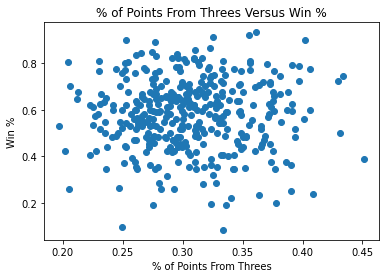


Null Hypothesis: Any difference between zero and the pearson correlation coefficient for % of Points From Threes and Win % is purely due to chance.

Pearson correlation coefficient between % of Points From Threes and Win %: 0.007387357204170295

Pearson correlation coefficent two-tailed p-value between % of Points From Threes and Win %: 0.8858687465660365

We fail to reject the null hypothesis. There is insufficent evidence to conclude a significant linear relationship between % of Points From Threes and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(percPointsFromThrees, winPercent, '% of Points From Threes', 'Win %')

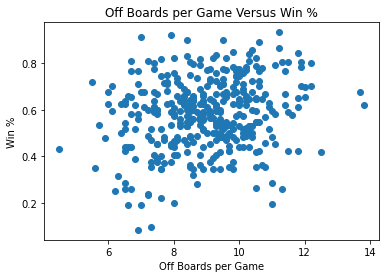

Correlation Coefficient Between Off Boards per Game and Win %: 0.20634073411765588


In [ ]:
plotRelationship(offBoards, winPercent, 'Off Boards per Game', 'Win %')

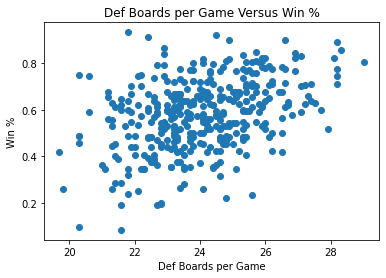


Correlation Coefficient Between Def Boards per Game and Win %: 0.39722109725771704

Correlation Coefficient p-value Between Def Boards per Game and Win %: 8.183789968020071e-16

There is a significant correlation between Def Boards per Game and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(defBoards, winPercent, 'Def Boards per Game', 'Win %')

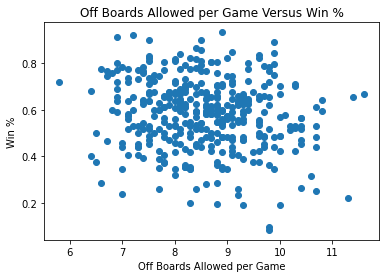


Correlation Coefficient Between Off Boards Allowed per Game and Win %: -0.14483180504782975

Correlation Coefficient p-value Between Off Boards Allowed per Game and Win %: 0.004670529538183238

There is a significant correlation between Off Boards Allowed per Game and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(offBoardsAllow, winPercent, 'Off Boards Allowed per Game', 'Win %')

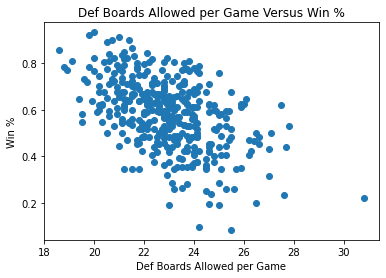


Correlation Coefficient Between Def Boards Allowed per Game and Win %: -0.5029443001129219

Correlation Coefficient p-value Between Def Boards Allowed per Game and Win %: 9.350525479800022e-26

There is a significant correlation between Def Boards Allowed per Game and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(defBoardsAllow, winPercent, 'Def Boards Allowed per Game', 'Win %')

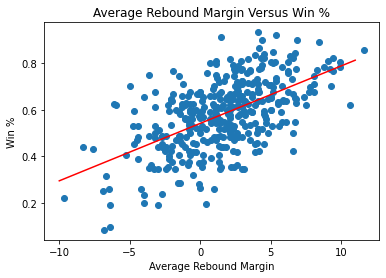


Null Hypothesis: Any difference between zero and the pearson correlation coefficient for Average Rebound Margin and Win % is purely due to chance.

Pearson correlation coefficient between Average Rebound Margin and Win %: 0.5693003159072764

Pearson correlation coefficent two-tailed p-value between Average Rebound Margin and Win %: 5.042548256520604e-34

Null hypothesis rejected! There is sufficent evidence to conclude significant linear relationship between Average Rebound Margin and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(reboundMargin, winPercent, 'Average Rebound Margin', 'Win %')

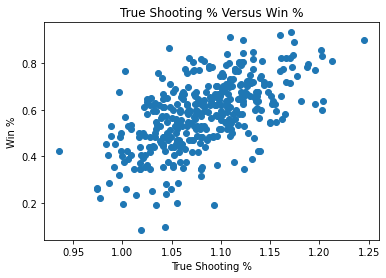


Correlation Coefficient Between True Shooting % and Win %: 0.5879116026182447

Correlation Coefficient p-value Between True Shooting % and Win %: 1.0735328770589524e-36

There is a significant correlation between True Shooting % and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(trueShooting, winPercent, 'True Shooting %', 'Win %')

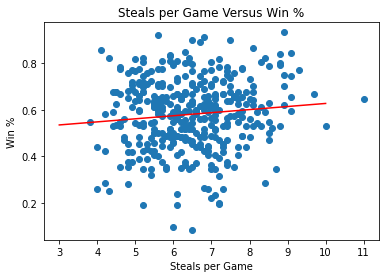


Null Hypothesis: Any difference between zero and the pearson correlation coefficient for Steals per Game and Win % is purely due to chance.

Pearson correlation coefficient between Steals per Game and Win %: 0.10357470985748657

Pearson correlation coefficent two-tailed p-value between Steals per Game and Win %: 0.04360990585959228

Null hypothesis rejected! There is sufficent evidence to conclude significant linear relationship between Steals per Game and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(steals, winPercent, 'Steals per Game', 'Win %')

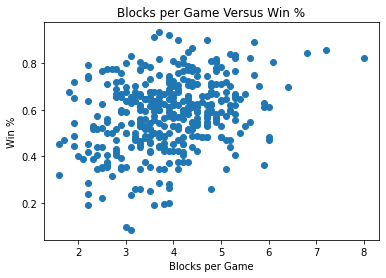


Correlation Coefficient Between Blocks per Game and Win %: 0.3097316171473489

Correlation Coefficient p-value Between Blocks per Game and Win %: 6.81712453938414e-10

There is a significant correlation between Blocks per Game and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(blocks, winPercent, 'Blocks per Game', 'Win %')

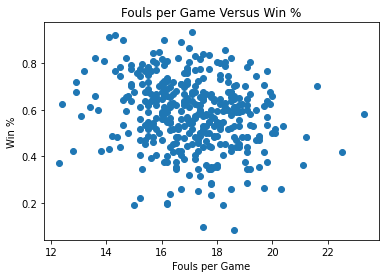


Correlation Coefficient Between Fouls per Game and Win %: -0.18817628952713192

Correlation Coefficient p-value Between Fouls per Game and Win %: 0.0002249992316306256

There is a significant correlation between Fouls per Game and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(fouls, winPercent, 'Fouls per Game', 'Win %')

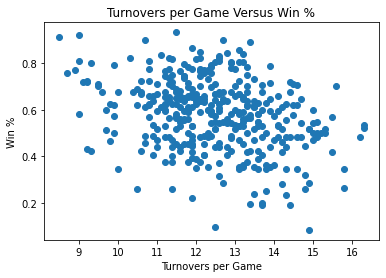


Correlation Coefficient Between Turnovers per Game and Win %: -0.3101056773154414

Correlation Coefficient p-value Between Turnovers per Game and Win %: 6.487082750852663e-10

There is a significant correlation between Turnovers per Game and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(turnovers, winPercent, 'Turnovers per Game', 'Win %')

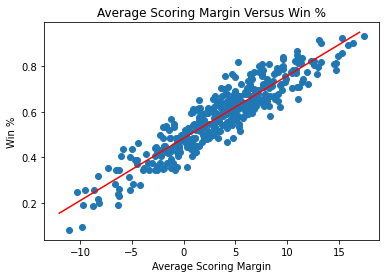


Null Hypothesis: Any difference between zero and the pearson correlation coefficient for Average Scoring Margin and Win % is purely due to chance.

Pearson correlation coefficient between Average Scoring Margin and Win %: 0.9233637367761861

Pearson correlation coefficent two-tailed p-value between Average Scoring Margin and Win %: 3.1119482883371155e-159

Null hypothesis rejected! There is sufficent evidence to conclude significant linear relationship between Average Scoring Margin and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(scoringMargin, winPercent, 'Average Scoring Margin', 'Win %')

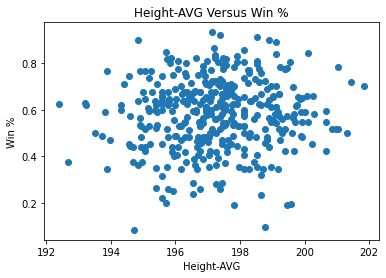


Null Hypothesis: Any difference between zero and the pearson correlation coefficient for Height-AVG and Win % is purely due to chance.

Pearson correlation coefficient between Height-AVG and Win %: 0.07467525732753569

Pearson correlation coefficent two-tailed p-value between Height-AVG and Win %: 0.14624532713572239

We fail to reject the null hypothesis. There is insufficent evidence to conclude a significant linear relationship between Height-AVG and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(heightsWeights, winPercent, 'Height-AVG', 'Win %')

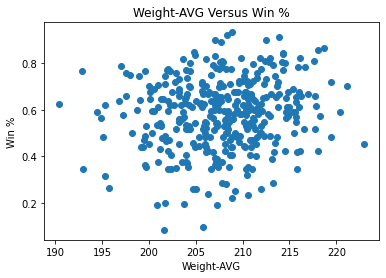


Null Hypothesis: Any difference between zero and the pearson correlation coefficient for Weight-AVG and Win % is purely due to chance.

Pearson correlation coefficient between Weight-AVG and Win %: 0.13978209911893483

Pearson correlation coefficent two-tailed p-value between Weight-AVG and Win %: 0.006347096224319149

Null hypothesis rejected! There is sufficent evidence to conclude significant linear relationship between Weight-AVG and Win % with a 0.05 p-value cutoff.


In [ ]:
plotRelationship(heightsWeights, winPercent, 'Weight-AVG', 'Win %')

In [ ]:
# Creating 3D scatter plot for 3 stats, also outputting pearson corr coefficient with p value
def threeDPlot(df1, df2, df3, colName1, colName2, colName3):
  df = pd.merge(df1, df2, on=['Team', 'Year'], how='inner')
  df = pd.merge(df, df3, on=['Team', 'Year'], how='inner')
  fig = go.Figure(data=[go.Scatter3d(x=df[colName1], y=df[colName2], z=df[colName3], mode='markers',\
                                     marker=dict(size=4, color=df[colName3], colorscale='Viridis', opacity=0.8, showscale=True))])
  fig.update_layout(autosize=True, margin=dict(l=10, r=10, b=50, t=50), title=colName1 + ' and ' + colName2 + ' Versus ' + colName3, showlegend=True,\
                    scene=layout.Scene(xaxis=XAxis(title=colName1), yaxis=YAxis(title=colName2), zaxis=ZAxis(title=colName3)))
  fig.show()

  corrCoeffic_xz = stats.pearsonr(df1[colName1], df3[colName3])
  corrCoeffic_yz = stats.pearsonr(df2[colName2], df3[colName3])
  corrCoeffic_xy = stats.pearsonr(df1[colName1], df2[colName2])
  multCorrCoeffic = math.sqrt(((corrCoeffic_xz[0]**2 + corrCoeffic_yz[0]**2)-(2*corrCoeffic_xz[0]*corrCoeffic_yz[0]*corrCoeffic_xy[0]))/(1 - corrCoeffic_xy[0]**2))
  print('The multiple correlation coefficient (R value) of the above graph is ' + str(multCorrCoeffic))

In [ ]:
threeDPlot(steals, fouls, winPercent, 'Steals per Game', 'Fouls per Game', 'Win %')

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:603: DeprecationWarning:

plotly.graph_objs.ZAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.scene.ZAxis




The multiple correlation coefficient (R value) of the above graph is 0.3983725351910903


In [ ]:
threeDPlot(reboundMargin, trueShooting, winPercent, 'Average Rebound Margin', 'True Shooting %', 'Win %')

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:603: DeprecationWarning:

plotly.graph_objs.ZAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.scene.ZAxis




The multiple correlation coefficient (R value) of the above graph is 0.5032669543116484


In [ ]:
# Sorting frame columns by team name and year, normalizing and converting to np array
def convertSortAndNormalize(df, colName):
  df = df.sort_values(['Team', 'Year'])
  col = df[colName]
  npCol = col.to_numpy()
  mean = np.mean(npCol)
  npCol = npCol - np.mean(npCol)
  std = np.std(npCol)
  npCol = npCol / np.std(npCol)
  if colName == 'Win %':
    return [mean, std, npCol]
  else:
    return npCol

In [ ]:
# Stacking stats together and transposing for proper shape
def stackTranspose(data):
  X = np.vstack(data)
  X = np.transpose(X)
  return X

In [ ]:
# Gathering, compiling, and normalizing stats for MLP regressor
np_reboundMargin = convertSortAndNormalize(reboundMargin, 'Average Rebound Margin')
np_steals = convertSortAndNormalize(steals, 'Steals per Game')
np_blocks = convertSortAndNormalize(blocks, 'Blocks per Game')
np_fouls = convertSortAndNormalize(fouls, 'Fouls per Game')
np_turnovers = convertSortAndNormalize(turnovers, 'Turnovers per Game')
np_weight = convertSortAndNormalize(heightsWeights, 'Weight-AVG')
# y is the labels
mean, std, y = convertSortAndNormalize(winPercent, 'Win %')
X = stackTranspose([np_reboundMargin, np_steals, np_blocks, np_fouls, np_turnovers, np_weight])

In [ ]:
# Training model with 80/20 split on features for past 5 seasons
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
regr = MLPRegressor(activation = 'tanh', max_iter=2000, hidden_layer_sizes=(12,6)).fit(X_train, y_train)
predict = regr.predict(X_test)
print(regr.score(X_test, y_test))
Z = np.vstack([y_test, predict])
Z = ((np.transpose(Z)) * std) + mean

0.605546965697603


In [ ]:
# Actual win percentages compared to predictions
print(Z)

[[0.771      0.7868097 ]
 [0.647      0.61871539]
 [0.73       0.70105862]
 [0.643      0.54819121]
 [0.375      0.46703701]
 [0.639      0.58172682]
 [0.921      0.81059302]
 [0.625      0.34221248]
 [0.722      0.75569385]
 [0.722      0.77720183]
 [0.543      0.5549871 ]
 [0.419      0.44990758]
 [0.811      0.64654045]
 [0.677      0.57094446]
 [0.355      0.49789566]
 [0.286      0.38861346]
 [0.667      0.64440219]
 [0.452      0.38816772]
 [0.625      0.67303842]
 [0.528      0.59607203]
 [0.469      0.44199451]
 [0.588      0.57697578]
 [0.5        0.50500997]
 [0.619      0.67444479]
 [0.588      0.54868748]
 [0.842      0.84598415]
 [0.79       0.70201516]
 [0.533      0.5352818 ]
 [0.636      0.60209683]
 [0.583      0.57967871]
 [0.546      0.62630284]
 [0.563      0.48044512]
 [0.419      0.48267392]
 [0.677      0.70659055]
 [0.75       0.63838287]
 [0.483      0.49710942]
 [0.8        0.68933615]
 [0.657      0.56724891]
 [0.485      0.52128394]
 [0.344      0.48135141]


In [ ]:
def ninetyPCA(X, initialDims):
  # Searching for minimum number of principal components needed to cover 90% of the eigenspace
  i = initialDims
  while i >= 0:
      pca = PCA(i)
      pca.fit_transform(X)
      print(i)
      print(sum(pca.explained_variance_ratio_))
      # Decreases amount of principal components until explained variance ratio is under .00, outputs one greater
      if sum(pca.explained_variance_ratio_) < 0.9:
        i = i + 1
        break
      else:
        i = i - 1
  pca = PCA(i)
  X_PCA = pca.fit_transform(X) 
  return X_PCA   

In [ ]:
# Compiling and normalizing stats for indicating playstyle and running PCA on it
np_possesPerGame = convertSortAndNormalize(possesPerGame, 'Possessions per Game')
np_threeRate = convertSortAndNormalize(threeRate, 'Three Rate')
np_assistPerPossess = convertSortAndNormalize(assistPerPossess, 'Assist per Possess')
np_foulsPerPossess = convertSortAndNormalize(foulsPerPossess, 'Fouls per Possess')
np_oppFoulsPerPossess = convertSortAndNormalize(oppFoulsPerPossess, 'Opp Fouls per Possess')
np_freeThrowsPerPossess = convertSortAndNormalize(freeThrowsPerPossess, 'Free Throws per Possess')
np_oppToPerPossess = convertSortAndNormalize(oppToPerPossess, 'Opp Turnovers per Possess')
Y = stackTranspose([np_possesPerGame, np_threeRate, np_assistPerPossess, np_foulsPerPossess, np_oppFoulsPerPossess,\
                    np_freeThrowsPerPossess, np_oppToPerPossess])
Y_PCA = ninetyPCA(Y, 7)

7
1.0
6
0.9854289049024533
5
0.9047871819944523
4
0.7875157217737176


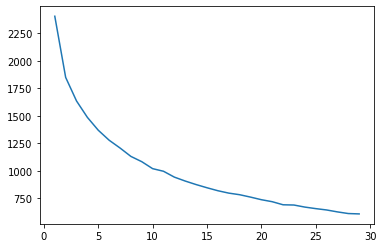

In [ ]:
# Plotting for elbow method
ks = range(1,30)
inertias = []
for k in ks:
  kmeans = KMeans(init="random", n_clusters=k).fit(Y_PCA)
  inertias.append(kmeans.inertia_)
plt.plot(ks, inertias)
plt.show()

In [ ]:
# Running k means with optimal k value gathered from elbow method
kmeans = KMeans(init="random", n_clusters=10).fit(Y_PCA)
winPercent = winPercent[['Team', 'Year', 'Win %']].sort_values(['Team', 'Year'])
winPercent['Cluster'] = kmeans.labels_
print(winPercent)

        Team  Year  Win %  Cluster
48   Alabama  2018  0.556        3
125  Alabama  2019  0.529        0
204  Alabama  2020  0.516        4
230  Alabama  2021  0.788        4
343  Alabama  2022  0.576        4
..       ...   ...    ...      ...
3     Xavier  2018  0.829        6
120   Xavier  2019  0.543        0
193   Xavier  2020  0.594        0
259   Xavier  2021  0.619        8
333   Xavier  2022  0.639        0

[380 rows x 4 columns]


In [ ]:
# Gathering mean and median win percentage of each cluster
for i in range(10):
  mean = winPercent[winPercent['Cluster'] == i]['Win %'].mean()
  median = winPercent[winPercent['Cluster'] == i]['Win %'].median()
  print('Mean Win Percentage of Cluster', str(i) + ':', mean)
  print('Median Win Percentage of Cluster', str(i) + ':', median)
  print('')

Mean Win Percentage of Cluster 0: 0.5788499999999999
Median Win Percentage of Cluster 0: 0.581

Mean Win Percentage of Cluster 1: 0.5094333333333333
Median Win Percentage of Cluster 1: 0.4925

Mean Win Percentage of Cluster 2: 0.594861111111111
Median Win Percentage of Cluster 2: 0.6094999999999999

Mean Win Percentage of Cluster 3: 0.5850888888888891
Median Win Percentage of Cluster 3: 0.6

Mean Win Percentage of Cluster 4: 0.5194166666666666
Median Win Percentage of Cluster 4: 0.551

Mean Win Percentage of Cluster 5: 0.6089374999999999
Median Win Percentage of Cluster 5: 0.621

Mean Win Percentage of Cluster 6: 0.72
Median Win Percentage of Cluster 6: 0.722

Mean Win Percentage of Cluster 7: 0.5248913043478259
Median Win Percentage of Cluster 7: 0.525

Mean Win Percentage of Cluster 8: 0.6168787878787878
Median Win Percentage of Cluster 8: 0.622

Mean Win Percentage of Cluster 9: 0.6045365853658536
Median Win Percentage of Cluster 9: 0.611



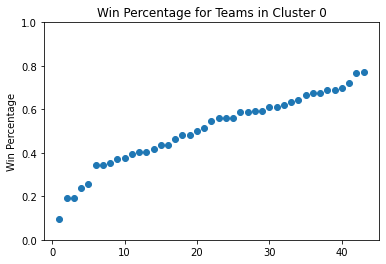

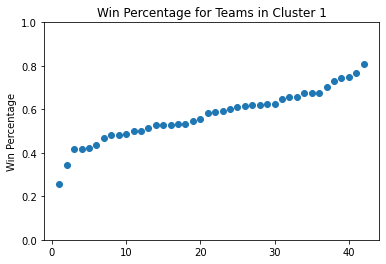

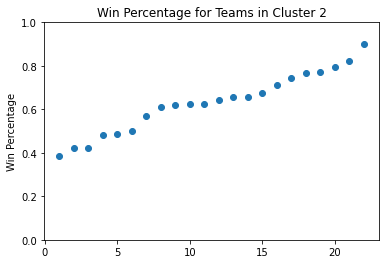

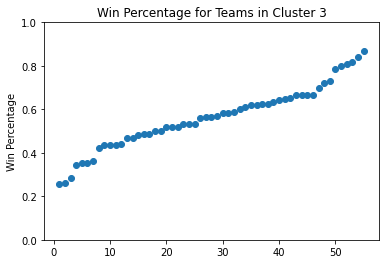

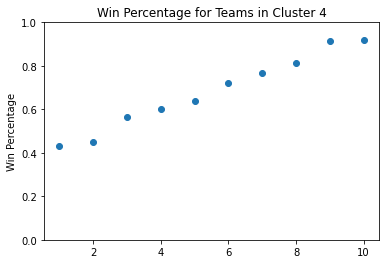

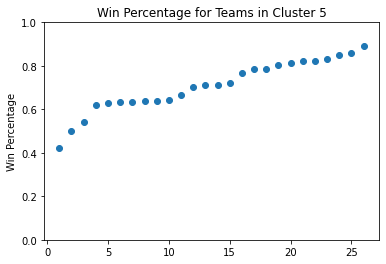

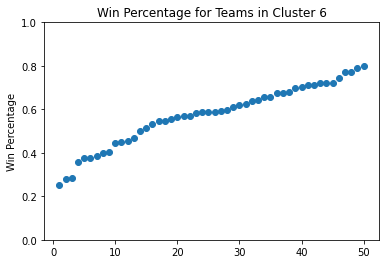

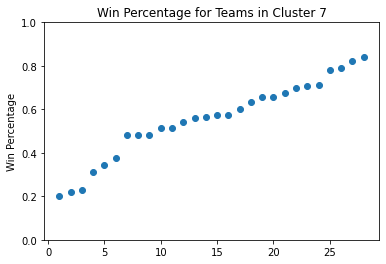

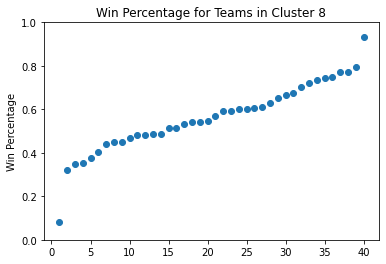

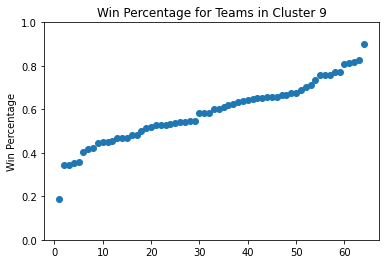

In [ ]:
# Plotting win percentages of teams in each cluster (ascending order)
winPercent = winPercent.sort_values('Win %')
for i in range(10):
  cluster = winPercent[winPercent['Cluster'] == i]
  plt.scatter(x=range(1,len(cluster) + 1), y=cluster['Win %'])
  plt.title('Win Percentage for Teams in Cluster ' + str(i))
  plt.ylabel('Win Percentage')
  plt.ylim(0,1)
  plt.savefig('TeamsInCluster' + str(i) + 'WinPerc.png', dpi=1000)
  plt.show()

In [ ]:
# Cluster with highest performing teams
print(winPercent[winPercent['Cluster'] == 1][['Team', 'Year']])
print('')
print('')
print('')
# Cluster with highest performing teams
print(winPercent[winPercent['Cluster'] == 6][['Team', 'Year']])

            Team  Year
74    California  2018
225   Vanderbilt  2020
143   W Virginia  2019
67      Illinois  2018
141   Pittsburgh  2019
219   California  2020
218  Mississippi  2020
211     Missouri  2020
132   S Carolina  2019
357   W Virginia  2022
58     Oregon St  2018
56    S Carolina  2018
55       Indiana  2018
353   Vanderbilt  2022
123   Providence  2019
124     Arkansas  2019
122      Arizona  2019
201    Texas A&M  2020
199    Tennessee  2020
48       Alabama  2018
195   S Carolina  2020
108     Syracuse  2019
262    Oregon St  2021
192         UCLA  2020
187   Providence  2020
260     Missouri  2021
258   Texas Tech  2021
35      Syracuse  2018
33    Arizona St  2018
184     Arkansas  2020
329        Texas  2022
174      Arizona  2020
24      Arkansas  2018
18     Kansas St  2018
168   W Virginia  2020
96    Arizona St  2019
14    W Virginia  2018
12    Texas Tech  2018
10     Tennessee  2018
86    Washington  2019
9         Auburn  2018
155       Auburn  2020



        